# Challenge

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

## Base Model

In [2]:
class Model(object):
    
    def train(self, X_train, Y_train):
        """
        Train of th model.
        Inputs:
            X_train {DataFrame}: Features of the training data
            Y_train {DataFrame}: Labels of the training data
        Output:
             None
        """
        raise NotImplementedError
    
    def predict(self, X_test):
        """
        Train of th model.
        Inputs:
            X_test {DataFrame}: Features of the test data
        Output:
            Y_pred {DataFrame}: Predictions of the input test data
        """
        raise NotImplementedError
        
    def validate(self, Y_pred, Y_test):
        """
        Compute the F-1 score for the results of the model
        Inputs:
            Y_pred {Pandas Series}: Predictions of the model
            Y_test {Pandas Series}: Groud truth
        Output:
            F-1 score of the prediction {Float}
        """
        return f1_score(Y_test, Y_pred, average='binary')
    
    def cross_validation(self, X_train, Y_train, kfold=5):
        """
        K-fold cross validation of the model.
        Inputs:
            X_train {DataFrame}: Train features.
            Y_train {DataFrame}: Train labels.
        Output:
            Mean f-1 score with confidence intervals
        """
        kf = KFold(n_splits=kfold)
        f1_scores = []
        
        for train_index, test_index in kf.split(X_train):
            X_tr = X_train.iloc[train_index].reset_index(drop=True)
            X_ts = X_train.iloc[test_index].reset_index(drop=True)
            
            Y_tr = Y_train.iloc[train_index].reset_index(drop=True)
            Y_ts = Y_train.iloc[test_index].reset_index(drop=True)
            
            # Train the model
            self.train(X_tr, Y_tr)
            
            # Test the model
            Y_pred = self.predict(X_ts)
            
            # Evaluate the model
            f1_scores.append(self.validate(Y_pred,Y_ts))
        se = scipy.stats.sem(f1_scores)
        print('F-1 Score: '+str(np.mean(f1_scores))+' \pm '+str(se*scipy.stats.t.ppf((1 + 0.95) / 2., kfold-1)))


# Models

#### Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestModel(Model):
    def train(self, X_train, Y_train):
        self.model = RandomForestClassifier(n_estimators=100,n_jobs=-1,
                                           class_weight='balanced')
        self.model.fit(X_train, Y_train.values.ravel())
        
    def predict(self, X_test):
        return self.model.predict(X_test)

df = pd.read_csv('./Dataset_booklet/accidents.csv')

# Import the (transformed) data
train_X = df[['number_of_vehicles','number_of_casualties',
              '1st_road_class','weather_conditions',
              'road_surface_conditions', 'carriageway_hazards',
              'urban_or_rural_area']]
train_Y = df[['target']]

train_X_2 = pd.get_dummies(train_X, columns=['1st_road_class','road_surface_conditions','carriageway_hazards','urban_or_rural_area'])

# K-fold the model
RandomForestModel().cross_validation(train_X_2, train_Y, kfold=3)

F-1 Score: 0.32544854719957783 \pm 0.06755644952856563


#### XGBoost

In [42]:
import xgboost as xgb
from sklearn.utils import class_weight

class XGBoostModel(Model):
    def train(self, X_train, Y_train):
        self.model = xgb.XGBClassifier(max_depth=5,n_jobs=-1,
                                       objective='binary:logistic',
                                       #scale_pos_weight=5,
                                       n_estimators=200)
        weights = class_weight.compute_sample_weight('balanced',Y_train.values)
        self.model.fit(X_train, Y_train.values.ravel(),
                      sample_weight=weights)
        
    def predict(self, X_test):
        return self.model.predict(X_test)
    
df = pd.read_csv('./Dataset_booklet/accidents.csv')

# Import the (transformed) data
train_X = df[['number_of_vehicles','number_of_casualties',
              '1st_road_class','weather_conditions',
              'road_surface_conditions', 'carriageway_hazards',
              'urban_or_rural_area']]
train_Y = df[['target']]

train_X_2 = pd.get_dummies(train_X, columns=['1st_road_class','road_surface_conditions','carriageway_hazards','urban_or_rural_area'])

# K-fold the model
XGBoostModel().cross_validation(train_X_2, train_Y, kfold=3)

F-1 Score: 0.33225830050327154 \pm 0.07269314772430181


In [66]:
import xgboost as xgb
from sklearn.utils import class_weight

class XGBoostModel(Model):
    def train(self, X_train, Y_train):
        self.model = xgb.XGBClassifier(max_depth=6,n_jobs=-1,
                                       objective='binary:logistic',
                                       #scale_pos_weight=5,
                                       n_estimators=200)
        weights = class_weight.compute_sample_weight('balanced',Y_train.values)
        self.model.fit(X_train, Y_train.values.ravel(),
                      sample_weight=weights)
        
    def predict(self, X_test):
        return self.model.predict(X_test)
    
df = pd.read_csv('./Dataset_booklet/accidents.csv')

# Import the (transformed) data
train_X = df[['number_of_vehicles','number_of_casualties','pedestrian_crossing-human_control',
              '1st_road_class','weather_conditions','light_conditions', 'speed_limit',
              'road_surface_conditions', 'carriageway_hazards',
              'urban_or_rural_area']]

def get_features_1(x):
    return x['number_of_casualties']/x['number_of_vehicles']

train_X['causalities_per_vehicle'] = train_X.apply(lambda x:get_features_1(x), axis=1)
train_Y = df[['target']]

train_X_2 = pd.get_dummies(train_X, columns=['1st_road_class','light_conditions','pedestrian_crossing-human_control',
                                             'road_surface_conditions','carriageway_hazards',
                                             'urban_or_rural_area'])

# K-fold the model
mod = XGBoostModel()
mod.cross_validation(train_X_2, train_Y, kfold=3)

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


F-1 Score: 0.33792556275130475 \pm 0.07338105887607414


array(['Darkness - lights unlit', 'Darkness - lights lit', 'Daylight',
       'Darkness - no lighting', 'Darkness - lighting unknown', '-1'],
      dtype=object)

In [68]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

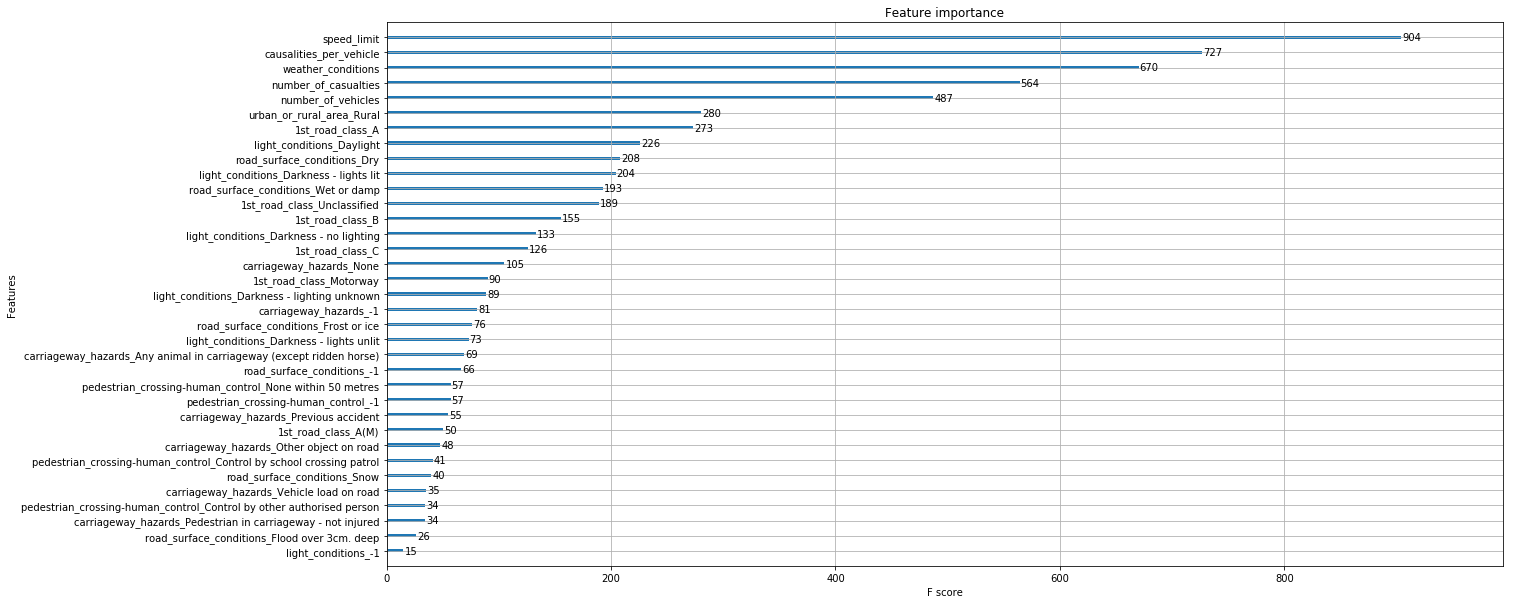

In [69]:
plot_importance(mod.model)
plt.show()

#### MLP

In [43]:
from sklearn.neural_network import MLPClassifier

In [48]:
class MLPModel(Model):
    def train(self, X_train, Y_train):
        self.model = MLPClassifier(hidden_layer_sizes=(20,20,10,2),
                                   activation='relu',max_iter=2000)
        self.model.fit(X_train, Y_train.values.ravel())
        
    def predict(self, X_test):
        return self.model.predict(X_test)

In [49]:
df = pd.read_csv('./Dataset_booklet/accidents.csv')

# Import the (transformed) data
train_X = df[['number_of_vehicles','number_of_casualties',
              '1st_road_class','weather_conditions',
              'road_surface_conditions', 'carriageway_hazards',
              'urban_or_rural_area']]
train_Y = df[['target']]

train_X_2 = pd.get_dummies(train_X, columns=['1st_road_class','road_surface_conditions','carriageway_hazards','urban_or_rural_area'])

# K-fold the model
MLPModel().cross_validation(train_X_2, train_Y, kfold=3)

F-1 Score: 0.008059073583280998 \pm 0.01658578744709147


## Preprocessing

In [154]:
from datetime import datetime
from datetime import time

df = pd.read_csv('./Dataset_booklet/accidents.csv')

# Import the (transformed) data
train_X = df[['accident_id','number_of_vehicles','number_of_casualties','pedestrian_crossing-human_control','road_type',
              '1st_road_class','weather_conditions','light_conditions', 'speed_limit','2nd_road_class',
              'road_surface_conditions', 'carriageway_hazards','junction_detail','junction_control',
              'urban_or_rural_area','time','special_conditions_at_site']]

def imputation_light_conditions(x):
    if x['light_conditions']=='-1':
        if datetime.strptime(x['time'], '%H:%M').time()>time(7,0) and datetime.strptime(x['time'], '%H:%M').time()<time(19,0):
            return 0
        else:
            return 3
    else:
        if x['light_conditions']=='Daylight':
            return 0
        elif x['light_conditions']=='Darkness - lights lit':
            return 1
        elif x['light_conditions']=='Darkness - lighting unknown':
            return 3
        else:
            return 2
        
def imputation_1st_road_class(x):
    if x['1st_road_class']=='Motorway':
        return 1
    elif x['1st_road_class']=='A(M)':
        return 2
    elif x['1st_road_class']=='A':
        return 3
    elif x['1st_road_class']=='B':
        return 4
    elif x['1st_road_class']=='C':
        return 5
    elif x['1st_road_class']=='Unclassified':
        return 6
    
def imputation_2nd_road_class(x):
    if x['2nd_road_class']=='Motorway':
        return 1
    elif x['2nd_road_class']=='A(M)':
        return 2
    elif x['2nd_road_class']=='A':
        return 3
    elif x['2nd_road_class']=='B':
        return 4
    elif x['2nd_road_class']=='C':
        return 5
    elif x['2nd_road_class']=='Unclassified':
        return 6
    else:
        return 7

    
def imputation_junction_detail(x):
    if x['junction_detail'] in ['Roundabout','Mini-roundabout']:
        return 'Roundabout'
    else:
        return 'Junction'
    
def imputtion_junction_control(x):
    if x['junction_control']=='-1':
        return 1
    elif x['junction_control'] in ['Give way or uncontrolled','Not at junction or within 20 metres']:
        return 0
    else:
        return 2
    
def imputation_pedestrian_crossing_human_control(x):
    if x['pedestrian_crossing-human_control']=='None within 50 metres':
        return 0
    elif x['pedestrian_crossing-human_control']=='-1':
        return 1
    else:
        return 2
    
def imputate_is_dry(x):
    if x['road_surface_conditions']=='Dry':
        return 2
    elif x['road_surface_conditions']=='-1':
        return 1
    else:
        return 0

def imputate_is_frozen(x):
    if x['road_surface_conditions'] in ['Frost or ice','Snow']:
        return 2
    elif x['road_surface_conditions']=='-1':
        return 1
    else:
        return 0
    
def imputate_special_conditions_at_site(x):
    if x['special_conditions_at_site'] in ['-1','None']:
        return 0
    else:
        return 1
    
def imputate_carriageway_hazards(x):
    if x['carriageway_hazards']=='None':
        return 0
    elif x['carriageway_hazards'] in ['-1','Pedestrian in carriageway - not injured']:
        return 1
    else:
        return 2

def imputate_is_urban(x):
    if x['urban_or_rural_area']=='Urban':
        return 1
    else:
        return 0
    
    
train_X['light_conditions'] = train_X.apply(lambda x:imputation_light_conditions(x), axis=1)
train_X['1st_road_class'] = train_X.apply(lambda x:imputation_1st_road_class(x), axis=1)
train_X['2nd_road_class'] = train_X.apply(lambda x:imputation_2nd_road_class(x), axis=1)
train_X['junction_detail'] = train_X.apply(lambda x:imputation_junction_detail(x), axis=1)
train_X['junction_control'] = train_X.apply(lambda x:imputtion_junction_control(x), axis=1)
train_X['pedestrian_crossing-human_control'] = train_X.apply(lambda x:imputation_pedestrian_crossing_human_control(x), axis=1)
train_X['is_dry'] = train_X.apply(lambda x:imputate_is_dry(x), axis=1)
train_X['is_frozen'] = train_X.apply(lambda x:imputate_is_frozen(x), axis=1)
train_X['special_conditions_at_site'] = train_X.apply(lambda x:imputate_special_conditions_at_site(x), axis=1)
train_X['carriageway_hazards'] = train_X.apply(lambda x:imputate_carriageway_hazards(x), axis=1)
train_X['urban_or_rural_area'] = train_X.apply(lambda x:imputate_is_urban(x), axis=1)
train_X['light_conditions'] = pd.to_numeric(train_X['light_conditions'])
train_X['1st_road_class'] = pd.to_numeric(train_X['1st_road_class'])
train_X['2nd_road_class'] = pd.to_numeric(train_X['2nd_road_class'])
train_X['pedestrian_crossing-human_control'] = pd.to_numeric(train_X['pedestrian_crossing-human_control'])
train_X['special_conditions_at_site'] = pd.to_numeric(train_X['special_conditions_at_site'])
train_X['carriageway_hazards'] = pd.to_numeric(train_X['carriageway_hazards'])
train_X['urban_or_rural_area'] = pd.to_numeric(train_X['urban_or_rural_area'])

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

### Data from vehicles

In [157]:
vehicles_df = pd.read_csv('./Dataset_booklet/vehicles.csv')

In [158]:
vehicles_df.columns

Index(['accident_id', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Engine_Capacity_(CC)', 'Propulsion_Code', 'Age_of_Vehicle',
       'Driver_IMD_Decile', 'Driver_Home_Area_Type', 'Vehicle_IMD_Decile'],
      dtype='object')

In [167]:
vehicles_df['is_male'] = vehicles_df.apply(lambda x: 1 if (x['Sex_of_Driver']=='Male') else 0, axis=1)
vehicles_df['is_women'] = vehicles_df.apply(lambda x: 0 if (x['Sex_of_Driver']=='Male') else 1, axis=1)
df_test = vehicles_df[['accident_id','is_male','is_women']]

In [168]:
is_male = df_test.groupby(['accident_id']).mean().reset_index()
is_male.columns = ['accident_id','num_males', 'num_women']
print(is_male.head())
merged_data = pd.merge(train_X, is_male, how='left', on='accident_id')
train_extra_X = merged_data[['num_males','num_women']].fillna(0)
print(train_extra_X.head())

def are_males(x):
    if x['num_males']>=1:
        return 1
    else:
        return 0
    
train_extra_X['num_males'] = train_extra_X.apply(lambda x:are_males(x), axis=1)
train_extra_X.head()

   accident_id  num_males  num_women
0       300000        0.0        1.0
1       300001        1.0        0.0
2       300002        0.5        0.5
3       300003        0.0        1.0
4       300004        0.5        0.5


KeyError: 'accident_id'

In [161]:
final_df = pd.concat([train_X, train_extra_X], axis=1, sort=False)
train_X = final_df

## Final modelling

In [162]:
import xgboost as xgb
from sklearn.utils import class_weight

class XGBoostModel(Model):
    def train(self, X_train, Y_train):
        self.model = xgb.XGBClassifier(max_depth=6,n_jobs=-1,
                                       objective='binary:logistic',
                                       #scale_pos_weight=5,
                                       n_estimators=200)
        weights = class_weight.compute_sample_weight('balanced',Y_train.values)
        self.model.fit(X_train, Y_train.values.ravel(),
                      sample_weight=weights)
        
    def predict(self, X_test):
        return self.model.predict(X_test)
    
train_X = train_X.drop(['time','road_surface_conditions','accident_id'],1)

def get_features_1(x):
    return x['number_of_casualties']/x['number_of_vehicles']

train_X['causalities_per_vehicle'] = train_X.apply(lambda x:get_features_1(x), axis=1)
train_Y = df[['target']]

train_X_2 = pd.get_dummies(train_X, columns=['junction_detail'])


# K-fold the model
mod = XGBoostModel()
mod.cross_validation(train_X_2, train_Y, kfold=3)

F-1 Score: 0.34222073820936944 \pm 0.08279092697680124


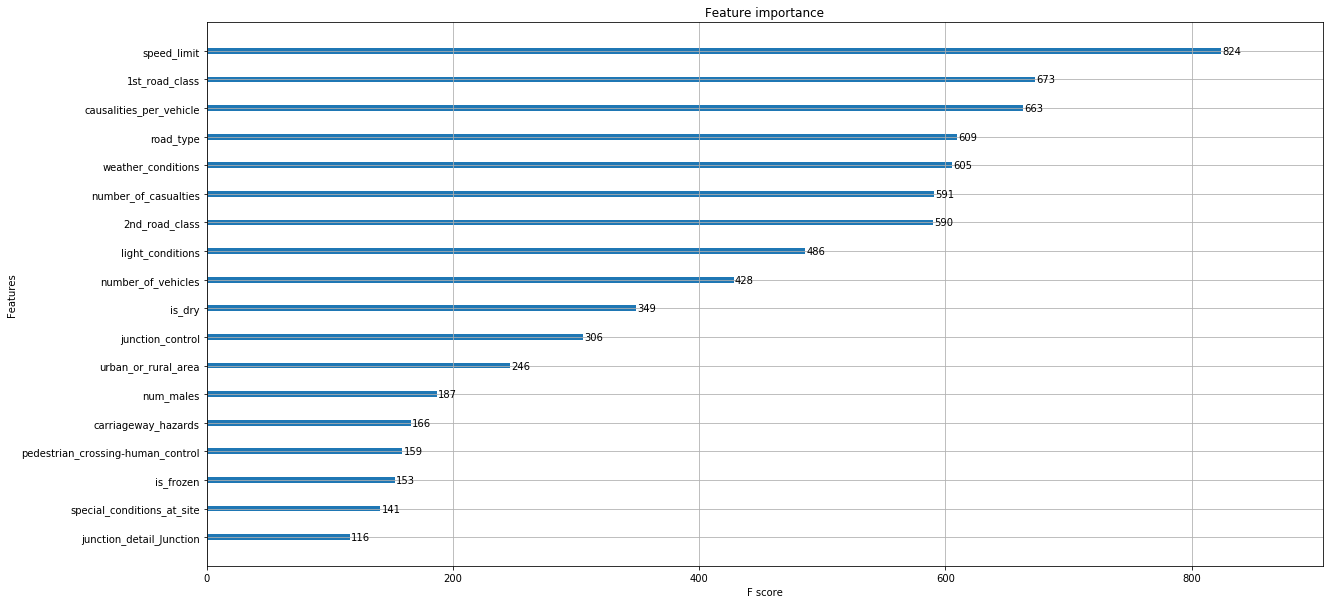

In [163]:
plot_importance(mod.model)
plt.show()